In [195]:
import torch
import torchvision.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
# PCA for feature inferred
from sklearn.decomposition import PCA
from skimage.filters import threshold_otsu



def get_dino_finetuned_downloaded(model_path, modelname):
    model = torch.hub.load("facebookresearch/dinov2", modelname)
    # load finetuned weights
    # pos_embed has wrong shape
    if model_path is not None:
        pretrained = torch.load(model_path, map_location=torch.device("cpu"))
        # make correct state dict for loading
        new_state_dict = {}
        for key, value in pretrained["teacher"].items():
            if "dino_head" in key or "ibot_head" in key:
                pass
            else:
                new_key = key.replace("backbone.", "")
                new_state_dict[new_key] = value
        # change shape of pos_embed
        input_dims = {
            "dinov2_vits14": 384,
            "dinov2_vitb14": 768,
            "dinov2_vitl14": 1024,
            "dinov2_vitg14": 1536,
        }
        pos_embed = nn.Parameter(torch.zeros(1, 257, input_dims[modelname]))
        model.pos_embed = pos_embed
        # load state dict
        model.load_state_dict(new_state_dict, strict=True)
    return model

import os
import random
from glob import glob

def get_random_class_images(folder_path, k, n):
    """
    Searches a folder for images, groups them by class (prefix before '_'), 
    and returns n random paths for k random classes.
    
    Parameters:
    - folder_path: Path to the folder containing the images.
    - k: Number of random classes to select.
    - n: Number of random images to select per class.
    
    Returns:
    A dictionary with class names as keys and lists of n random image paths as values.
    """
    # Find all image files in the specified folder
    image_paths = glob(os.path.join(folder_path, '*.jpeg'))
    
    # Extract classes and group image paths by class
    class_images = {}
    for path in image_paths:
        class_name = os.path.basename(path).split('_')[0]
        if class_name in class_images:
            class_images[class_name].append(path)
        else:
            class_images[class_name] = [path]
    
    # Select k random classes
    selected_classes = random.sample(list(class_images.keys()), k)
    print("selected classes:" ,selected_classes)
    # For each selected class, pick n random images
    #random_class_images = {cls: random.sample(class_images[cls], min(n, len(class_images[cls]))) for cls in selected_classes}
    random_images = [path for cls in selected_classes for path in random.sample(class_images[cls], min(n, len(class_images[cls])))]

    return random_images





In [225]:

model_path = "/mnt/ceph_vol/dinov2/models/vits_9999.pth"
modelname = "dinov2_vits14"

model = get_dino_finetuned_downloaded(model_path, modelname)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")
patch_h = 16
patch_w = 16
feat_dim = 384 # vits14
#feat_dim = 768 # vitb14
#feat_dim = 1024 # vitl14
#feat_dim = 1536 # vitg14
img_size=224

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])


dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
inov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

dinov2_vits14=model





Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main


Number of trainable parameters: 21629184


Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
 29%|██▉       | 335M/1.13G [00:03<00:08, 100MB/s]  


OSError: [Errno 28] No space left on device

In [226]:
trainable_params = sum(p.numel() for p in dinov2_vitb14.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 86580480


In [214]:

dir_path = "/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples"

num_classes=3
num_samples=3
paths = get_random_class_images(dir_path, num_classes, num_samples)
print(paths)
#paths = list(Path(dir_path).rglob("*.jpeg"))
#np.random.shuffle(paths)
print(len(paths))
images_for_plotting = [Image.open(img_path).convert('RGB').resize((img_size, img_size)) for img_path in paths]

# Plotting the images in a 2x2 grid
 # Remove axis
#plt.close()
# Modify the list comprehension to move each image tensor to CUDA
imgs_tensor = torch.stack([transform(Image.open(img_path).convert('RGB').resize((img_size,img_size))).cuda() for img_path in paths])
n_images=len(paths)
# Move your model to GPU
dinov2_vits14.cuda()

with torch.no_grad():
    # Ensure the input tensor is on GPU by calling .cuda() on it
    features_dict = dinov2_vits14.forward_features(imgs_tensor)
    features = features_dict['x_norm_patchtokens']




features = features.reshape(len(paths) * patch_h*patch_h, feat_dim).cpu().numpy()

pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)



selected classes: ['SNE', 'BA', 'PMY']
['/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/SNE_105867.jpeg', '/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/SNE_24470.jpeg', '/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/SNE_207762.jpeg', '/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/BA_175269.jpeg', '/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/BA_569593.jpeg', '/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/BA_177230.jpeg', '/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/PMY_490425.jpeg', '/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/PMY_722296.jpeg', '/mnt/ceph_vol/dinov2/dinov2/data/acevedo samples/PMY_757137.jpeg']
9


otsu optimal threshold: 5.0369043
9


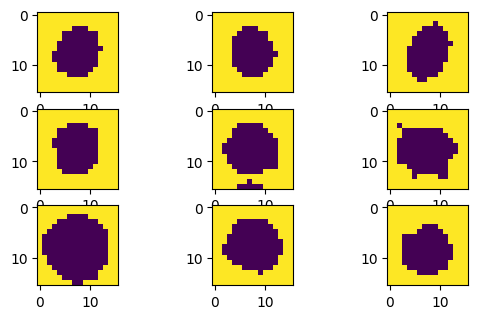

In [221]:
first_component = pca_features[:, 0]

# Use Otsu's method to find an optimal threshold
threshold = threshold_otsu(first_component)

print("otsu optimal threshold:", threshold)

# segment using the first component
pca_features_bg = pca_features[:, 0] <threshold
pca_features_fg = ~pca_features_bg

print(n_images)
# plot the pca_features_bg
for i in range(n_images):
    plt.subplot(4, 3, i+1)
    plt.imshow(pca_features_bg[i * patch_h*patch_w: (i+1) * patch_h*patch_w].reshape(patch_h, patch_w))
plt.show()




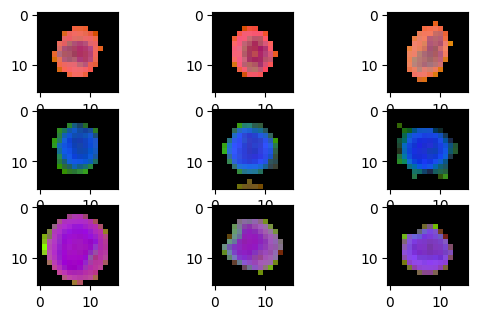

In [223]:
# PCA for only foreground patches
pca_features_rem = pca.transform(features[pca_features_fg])
for i in range(3):
    pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
    # transform using mean and std, I personally found this transformation gives a better visualization
    #pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

pca_features_rgb = pca_features.copy()
pca_features_rgb[pca_features_bg] = 0
pca_features_rgb[pca_features_fg] = pca_features_rem

pca_features_rgb = pca_features_rgb.reshape(n_images, patch_h, patch_w, 3)
for i in range(n_images):
    plt.subplot(4, 3, i+1)
    plt.imshow(pca_features_rgb[i][..., ::-1])
plt.savefig('features.png')
plt.show()
plt.close()

for i in range(n_images):
    # Step 1: Reshape PCA features to the original patch size
    img_array = pca_features_rgb[i][..., ::-1]
    
    # Convert the array to a PIL Image
    img_pil = Image.fromarray(np.uint8(img_array*255))
    
    # Step 2 & 3: Resize the image to 224x224 pixels
    img_resized = img_pil.resize((224, 224), Image.NEAREST)
    
    # Save the PIL image
    img_resized.save(f'image_{i+1}.png')

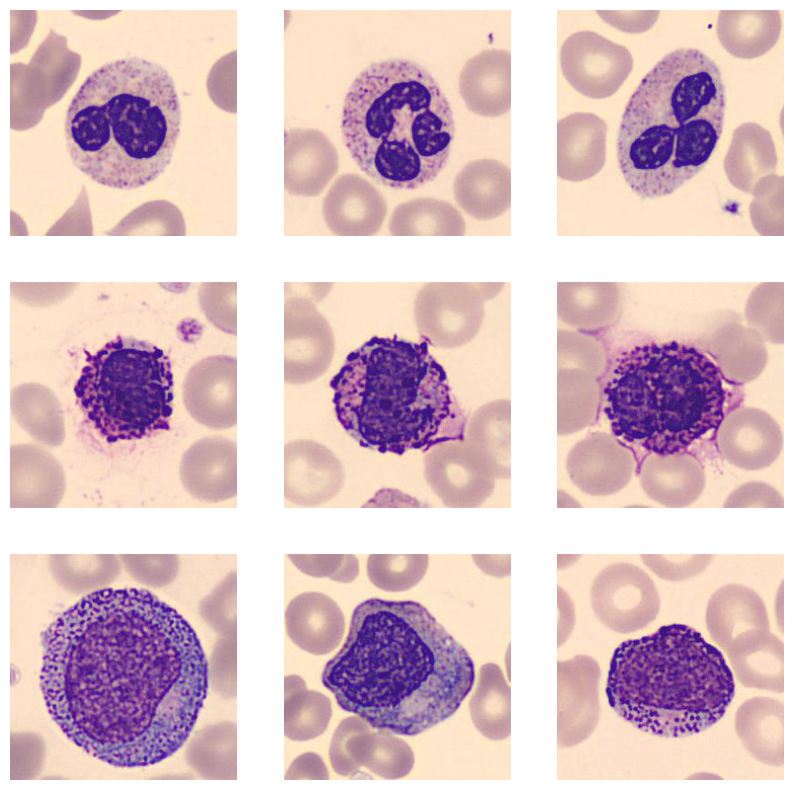

In [217]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    #print(Path(images_for_plotting[i]).stem)
    ax.imshow(images_for_plotting[i])
    ax.axis('off')  # Remove axis